In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import leastsq
import numpy as np
import pandas as pd
import sys
import os
import plotly.io as pio

sys.path.append("C:\\Users\\nigel\\OneDrive\\Desktop\\VS Code\\vasp-job-automation") #Change this to your path
import src.workflows as workflows    
import src.eos_fit as eos_fit
#Get current working directory



C:\Users\nigel\AppData\Local\Temp\ipykernel_11852\191553902.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
ion_list = [i for i in range(1, 9)] #recall that range(n, m) = [n, ..., m-1]

# directory that contains the all the 'config_x' dirs
configurations_dir = 'C:\\Users\\nigel\\OneDrive\\Desktop\\Pb\\PBE'

#make a list of all the 'config_x' dirs
config_dirs = [os.path.join(configurations_dir, d) for d in os.listdir(configurations_dir) if os.path.isdir(os.path.join(configurations_dir, d))]

df_list = []
for config_dir in config_dirs:
    config_df = workflows.extract_configuration_data(config_dir, outcar_name='OUTCAR.3static', contcar_name="CONTCAR.3static", oszicar_name='OSZICAR.3static') 
    df_list.append(config_df)

df = pd.concat(df_list, ignore_index=True)
df.loc[df['config'] == 'HCP', 'volume'] *= 16
df.loc[df['config'] == 'HCP', 'energy'] *= 16
df.loc[df['config'] == 'HCP', 'number_of_atoms'] *= 16
df['volume'] = round(df['volume'])
#print(df.loc[df['config'] == 'HCP'])
print(df)

     volume config      energy  number_of_atoms
0    1000.0    HCP -113.501467               32
1     990.0    HCP -113.440027               32
2     900.0    HCP -111.393110               32
3     890.0    HCP -110.958733               32
4     880.0    HCP -110.475656               32
..      ...    ...         ...              ...
134  1250.0   SCC1 -109.410240               32
135   940.0   SCC1 -112.626490               32
136   930.0   SCC1 -112.338050               32
137   920.0   SCC1 -112.008600               32
138   910.0   SCC1 -111.636850               32

[139 rows x 4 columns]


config  volume         HCP         NCC        SCC1  delta_SCC1  delta_HCP
0        710.0  -90.335080  -88.793167  -89.145872  -11.022031 -48.184781
1        720.0  -92.404896  -90.880967  -91.283451  -12.577625 -47.622781
2        730.0  -94.328146  -92.843804  -93.268464  -13.270625 -46.385675
3        740.0  -96.109037  -94.661937  -95.115452  -14.172344 -45.221869
4        750.0  -97.758630  -96.341209  -96.829594  -15.262031 -44.294419
5        760.0  -99.288696  -97.898455  -98.420590  -16.316719 -43.445031
6        770.0 -100.703680  -99.340242  -99.897989  -17.429594 -42.607438
7        780.0 -102.011954 -100.677500 -101.268480  -18.468125 -41.701675
8        790.0 -103.221107 -101.908350 -102.536210  -19.620625 -41.023663
9        800.0 -104.332638 -103.046250 -103.703030  -20.524375 -40.199637
10       810.0 -105.358886 -104.110840 -104.783150  -21.009688 -39.001450
11       820.0 -106.301155 -105.083810 -105.777800  -21.687187 -38.042037
12       830.0 -107.165344 -105.973770

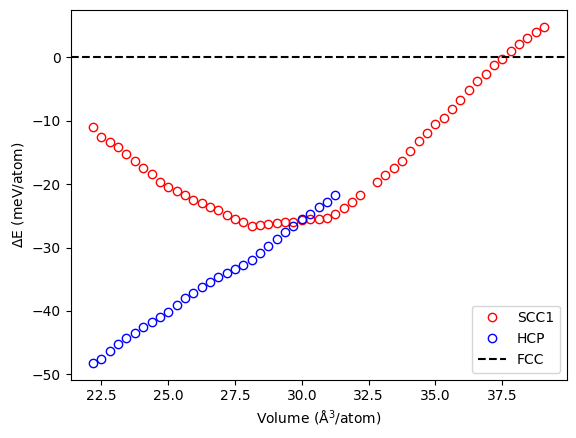

In [6]:
# Pivot the DataFrame
pivot_df = df.pivot(index='volume', columns='config', values='energy')

pivot_df['delta_SCC1'] = (pivot_df['SCC1'] - pivot_df['NCC'])/32*1000
pivot_df['delta_HCP'] = (pivot_df['HCP'] - pivot_df['NCC'])/32*1000
#pivot_df['delta_SCC2'] = (pivot_df['SCC2'] - pivot_df['NCC'])/32*1000
#pivot_df['delta_SCC3'] = (pivot_df['SCC3'] - pivot_df['NCC'])/32*1000
#pivot_df['delta_SCC4'] = (pivot_df['SCC4'] - pivot_df['NCC'])/32*1000

# Reset the index to turn 'volume' back into a column
result_df = pivot_df.reset_index()
print(result_df)
#Plot the energy difference as a function of volume
plt.plot(result_df['volume']/32, result_df['delta_SCC1'], 'o', markerfacecolor='none', markeredgecolor='r', label='SCC1')
plt.plot(result_df['volume']/32, result_df['delta_HCP'], 'o', markerfacecolor='none', markeredgecolor='b', label='HCP')
#plt.plot(result_df['volume']/32, result_df['delta_SCC2'], 'o', markerfacecolor='none', markeredgecolor='b')
#plt.plot(result_df['volume']/32, result_df['delta_SCC3'], 'o', markerfacecolor='none', markeredgecolor='g')
#plt.plot(result_df['volume']/32, result_df['delta_SCC4'], 'o', markerfacecolor='none')

# Adjust the y-axis
#plt.ylim(-0.20, 0)
plt.xlabel(r'Volume ($\mathrm{\AA}^3$/atom)')
plt.ylabel(r'$\Delta$E (meV/atom)')
#plot a horizontal line a y=0
plt.axhline(y=0, color='k', linestyle='--', label= 'FCC')
plt.legend()


In [4]:
fig = eos_fit.plot_ev(df, eos_fitting="BM4",per_atom=False, show_fig=True)
# Adjust the x-range of a plotly figure
fig.update_xaxes(range=[950,1100])
fig.update_yaxes(range=[-115,-105])



In [32]:
# Print the current directory
print(configurations_dir)
config_dir = os.path.join(configurations_dir, 'config_NCC')

vol_folders = [d for d in os.listdir(config_dir) if d.startswith('vol')]

for vol_folder in vol_folders:
    error_folders = [f for f in os.listdir(os.path.join(config_dir, vol_folder)) if f.startswith('error')]
    if len(error_folders) > 0:
        print(f'In {vol_folder} there are error folders: {error_folders}')



C:\Users\nigel\OneDrive\Desktop\Pb\
In vol_30 there are error folders: ['error.1.tar.gz', 'error.2.tar.gz']
